In [ ]:
#importing libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model

import matplotlib.pyplot as plt
import seaborn as sb

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading and Processing Data

In [ ]:
#path of data set
directory = "/content/drive/MyDrive/Medicinal Leaf Dataset"

In [ ]:
batch_size = 64
IMG_SIZE = (224, 224, 3)

In [ ]:
#creating train data set
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True,
    )

Found 2982 files belonging to 1 classes.
Using 2386 files for training.


In [ ]:
#creating train validation set
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True
    )

Found 2982 files belonging to 1 classes.
Using 596 files for validation.


In [ ]:
#getting the name of classes
class_names = train_ds.class_names

In [ ]:
#saving class names
np.save("/content/drive/MyDrive/artifact/updatedclass_names.npy", class_names)

In [ ]:
NUM_CLASSES = 39

## Sample of Training data

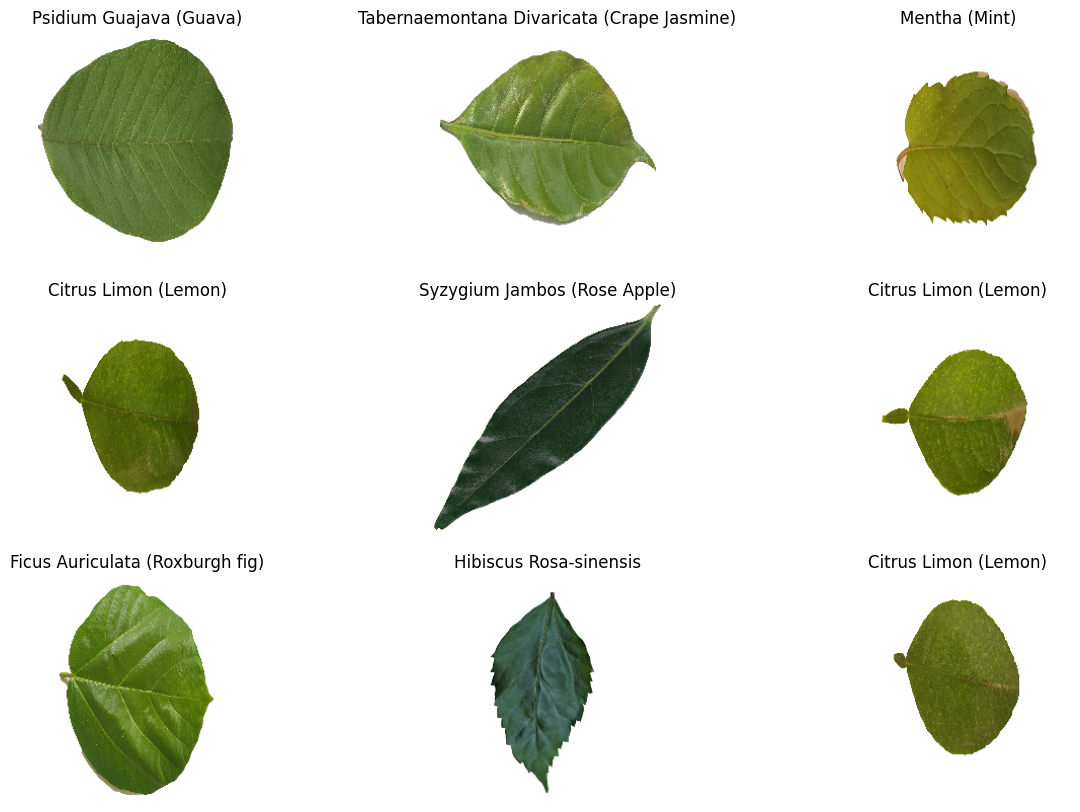

In [ ]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
#provides pipeling for reading data and training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

## Modelling

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

### Using Pre-Trained ResNet50V2

In [ ]:
#ResNet50V2 layers except for the last global average pooling and final dense layer.
pre_trained_layers = keras.applications.NASNetLarge(weights="imagenet", include_top=False, input_tensor=keras.Input(shape=IMG_SIZE))
#pre_trained_layers = keras.applications.NASNetLarge(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=IMG_SIZE))


343610240/343610240 [==============================] - 6s 0us/step


In [ ]:
pre_trained_layers.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 96)         2592      ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 96)         384       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 96)         0         ['stem_bn1[0][0]']       

In [ ]:
#freezing the layers of ResNet
pre_trained_layers.trainable = False

In [ ]:
pre_trained_layers.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 96)         2592      ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 96)         384       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 96)         0         ['stem_bn1[0][0]']       

In [ ]:
#Creating custom model
#NUM_CLASSES = 30
model = keras.Sequential([
    data_augmentation,                                                    # data augmentations
    pre_trained_layers,                                                   # ResNet pre-trained layers
    keras.layers.GlobalAveragePooling2D(),                                # Adding Global average Pooling 2d
    keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')  # Final Dense Layer with 30 neurons
])

In [ ]:
EPOCHS = 10
LR = 1e-3

In [ ]:
#LR = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#printing summary of custom model
model.build((1,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d (  (1, 4032)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 output (Dense)              (1, 39)                   157287    
                                                                 
Total params: 85074105 (324.53 MB)
Trainable params: 157287 (614.40 KB)
Non-trainable params: 84916818 (323.93 MB)
_________________________________________________________________


In [ ]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [ ]:
#training the model
#EPOCHS = 100
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds, callbacks=callback)

Epoch 1/10


In [ ]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(validation_ds)}")
epochs = 10
for epoch in range(epochs):
    # Train the model
    history = model.fit(train_ds, epochs=6, validation_data=validation_ds, callbacks=callback)

    # Get predictions on the validation set
    predictions = model.predict(validation_ds)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Identify misclassified samples
    misclassified_indices = tf.where(predicted_labels != validation_ds.labels)

    # Remove misclassified samples from training dataset
    train_ds = train_ds.unbatch().filter(lambda x, y: tf.reduce_all(tf.not_equal(tf.where(misclassified_indices == y), []))).batch(batch_size)

    # Prefetch and cache the modified training dataset
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train dataset size: 38
Validation dataset size: 10
Epoch 1/6
38/38 [==============================] - 1804s 47s/step - loss: 0.3853 - accuracy: 0.9837 - val_loss: 0.0145 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/6
38/38 [==============================] - 1610s 43s/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/6
38/38 [==============================] - 1685s 45s/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/6
 7/38 [====>.........................] - ETA: 18:03 - loss: 0.0132 - accuracy: 1.0000

In [ ]:
# Assuming `model` is your Keras model and `train_ds` is your training dataset

# Resume training for 2 more epochs
history = model.fit(train_ds, epochs=8, initial_epoch=6, validation_data=validation_ds, callbacks=callback)


Epoch 7/8
23/23 [==============================] - 1197s 53s/step - loss: 0.6631 - accuracy: 0.8460 - val_loss: 0.6528 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 8/8
23/23 [==============================] - 1167s 51s/step - loss: 0.5972 - accuracy: 0.8774 - val_loss: 0.6026 - val_accuracy: 0.8556 - lr: 0.0010


In [ ]:
#history = model.fit(train_ds, epochs=10, initial_epoch=8, validation_data=validation_ds, callbacks=callback)
from keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/artifact/modelunlearn.h5')

# Compile the model (if needed)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming `train_ds` and `validation_ds` are your training and validation datasets

# Train the model for 2 additional epochs
#history = model.fit(train_ds, epochs=12, initial_epoch=11, validation_data=validation_ds, callbacks=callback)




In [ ]:
history = model.fit(train_ds, epochs=11, initial_epoch=10, validation_data=validation_ds, callbacks=callback)


Epoch 11/11
23/23 [==============================] - 1163s 51s/step - loss: 0.4406 - accuracy: 0.9026 - val_loss: 0.4744 - val_accuracy: 0.8774 - lr: 0.0010


In [ ]:
# Get true labels from the validation dataset
predictions = model.predict(validation_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = []
for images, labels in validation_ds:
    true_labels.extend(labels.numpy())

# Convert to a TensorFlow tensor
true_labels = tf.convert_to_tensor(true_labels)
# Convert predicted labels to int64
predicted_labels = tf.cast(predicted_labels, tf.int32)

# Identify misclassified samples
misclassified_indices = tf.where(predicted_labels != true_labels)


# Identify misclassified samples
misclassified_indices = tf.where(predicted_labels != true_labels)
# Remove misclassified samples from training dataset
# Remove misclassified samples from training dataset
train_ds = train_ds.unbatch().filter(lambda x, y: tf.reduce_all(tf.not_equal(tf.where(tf.reduce_all(misclassified_indices == tf.cast(y, tf.int64), axis=1)), []))).batch(batch_size)
    # Prefetch and cache the modified training dataset
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


10/10 [==============================] - 345s 34s/step - loss: 0.0088 - accuracy: 1.0000
Test Accuracy: 100.00%


In [ ]:
print("True Label:", true_labels)
print("Predicted Label:", predicted_labels)
print("Misclassified Index:", misclassified_indices)

True Label: tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0

In [ ]:
misclassified_indices_numpy = misclassified_indices.numpy()
true_labels_numpy = true_labels.numpy()
predicted_labels_numpy = predicted_labels.numpy()
# Remove misclassified samples from training dataset
train_ds = train_ds.unbatch().filter(lambda x, y: tf.reduce_all(tf.not_equal(tf.where(tf.reduce_all(misclassified_indices == tf.cast(y, tf.int64), axis=1)), []))).batch(batch_size)

# Prefetch and cache the modified training dataset
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

for idx in misclassified_indices_numpy:
  print("True Label:", true_labels_numpy[idx])
  print("Predicted Label:", predicted_labels_numpy[idx])
  print("Misclassified Index:", idx)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 340s 34s/step - loss: 0.0088 - accuracy: 1.0000
Test Accuracy: 100.00%


In [ ]:
import matplotlib.pyplot as plt

# Iterate through misclassified indices and visualize images
for index in misclassified_indices:
    image, true_label = next(iter(validation_ds.unbatch().skip(index[0]).take(1)))  # Extract an individual image and label
    image = tf.expand_dims(image, axis=0)  # Add a batch dimension
    predicted_label = model.predict(image).argmax(axis=-1)[0]  # Predict label for the image

    # Plot the misclassified image along with true and predicted labels
    plt.imshow(image[0])
    plt.title(f'True label: {true_label}, Predicted label: {predicted_label}')
    plt.show()





In [ ]:
import numpy as np

# Load the contents of the file without conversion
class_names_data = np.load("/content/drive/MyDrive/artifact/class_names.npy", allow_pickle=True)

print(class_names_data)


['Alpinia Galanga (Rasna)' 'Amaranthus Viridis (Arive-Dantu)'
 'Artocarpus Heterophyllus (Jackfruit)' 'Azadirachta Indica (Neem)'
 'Basella Alba (Basale)' 'Brassica Juncea (Indian Mustard)'
 'Carissa Carandas (Karanda)' 'Citrus Limon (Lemon)'
 'Ficus Auriculata (Roxburgh fig)' 'Ficus Religiosa (Peepal Tree)'
 'Hibiscus Rosa-sinensis' 'Jasminum (Jasmine)' 'Mangifera Indica (Mango)'
 'Mentha (Mint)' 'Moringa Oleifera (Drumstick)'
 'Muntingia Calabura (Jamaica Cherry-Gasagase)' 'Murraya Koenigii (Curry)'
 'Nerium Oleander (Oleander)' 'Nyctanthes Arbor-tristis (Parijata)'
 'Ocimum Tenuiflorum (Tulsi)' 'Piper Betle (Betel)'
 'Plectranthus Amboinicus (Mexican Mint)'
 'Pongamia Pinnata (Indian Beech)' 'Psidium Guajava (Guava)'
 'Punica Granatum (Pomegranate)' 'Santalum Album (Sandalwood)'
 'Syzygium Cumini (Jamun)' 'Syzygium Jambos (Rose Apple)'
 'Tabernaemontana Divaricata (Crape Jasmine)'
 'Trigonella Foenum-graecum (Fenugreek)']


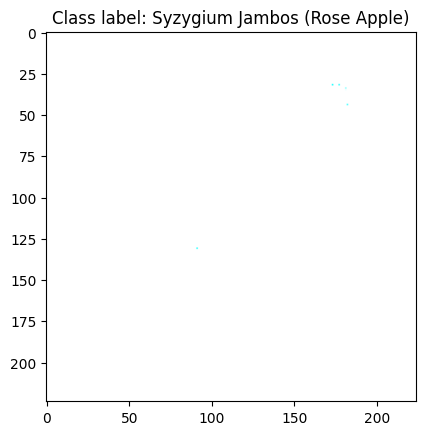

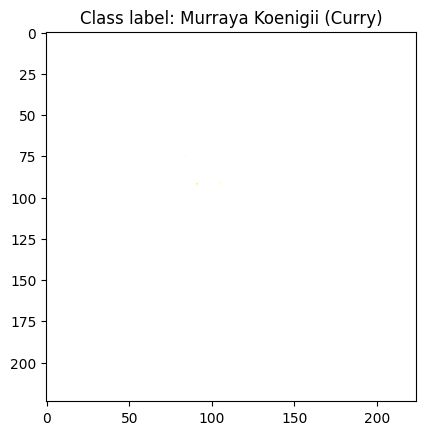

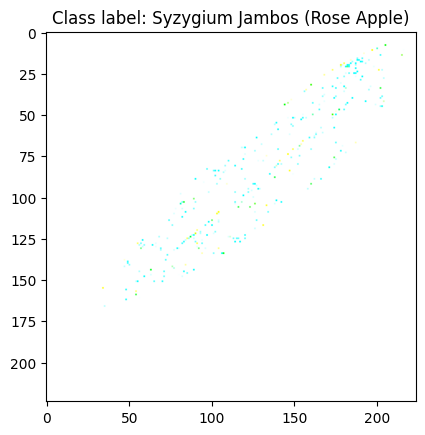

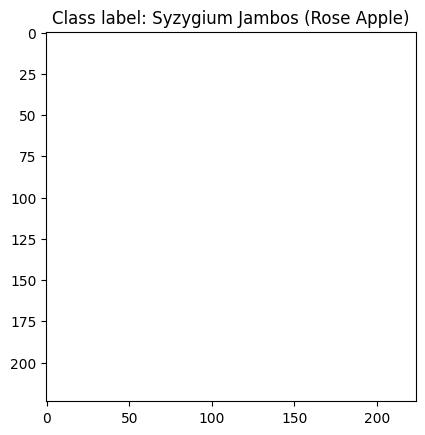

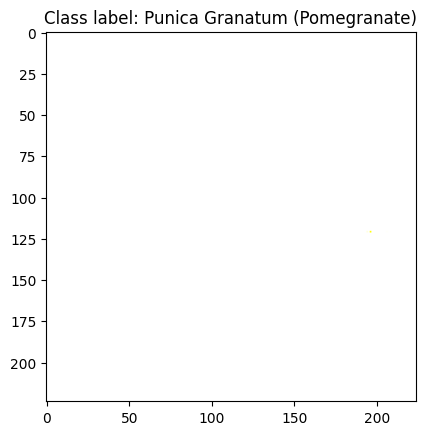

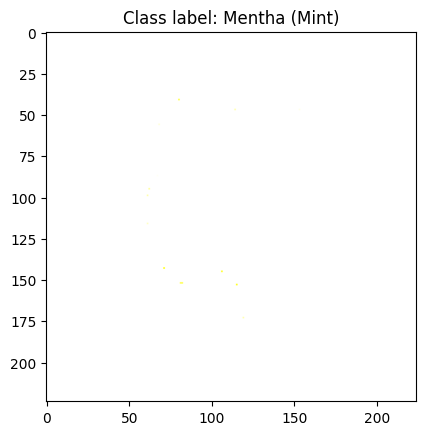

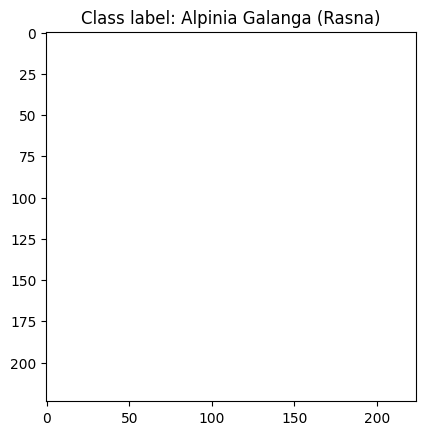

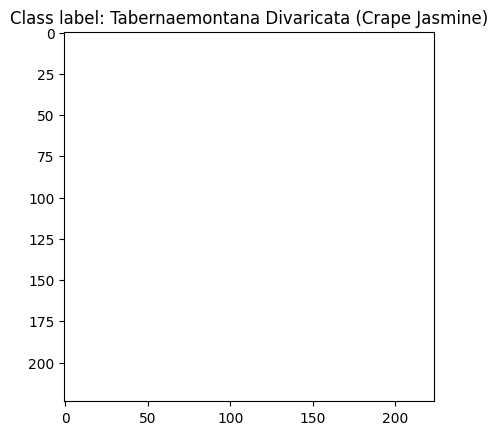

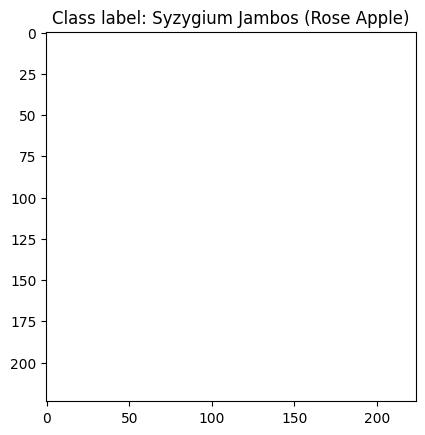

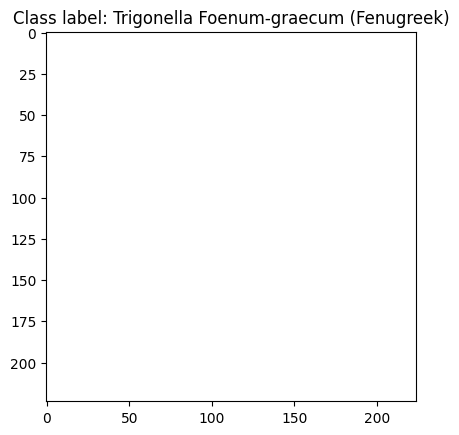

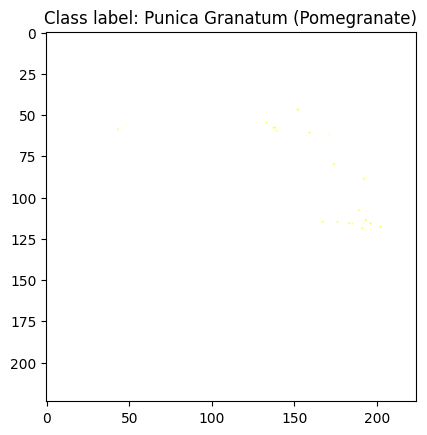

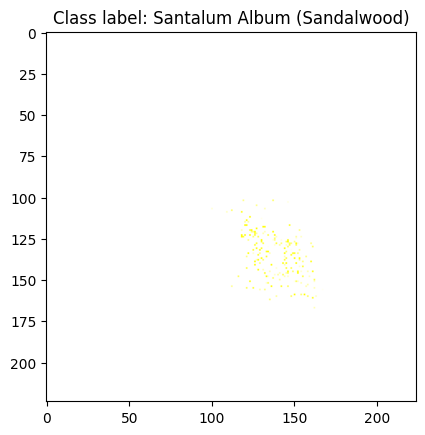

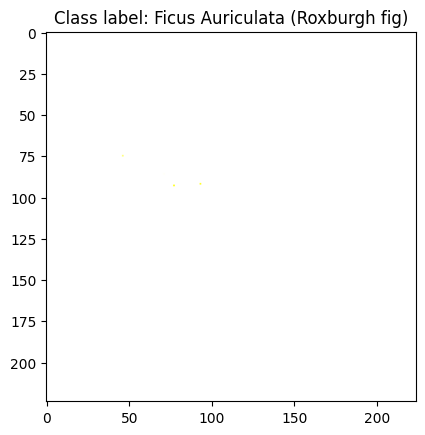

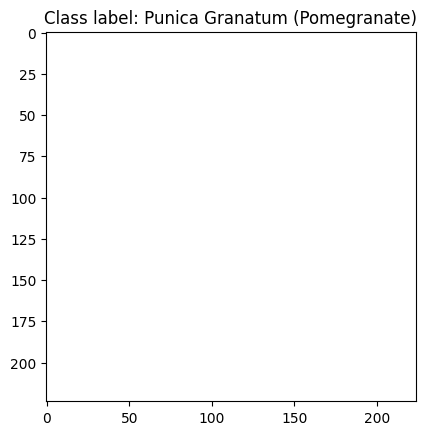

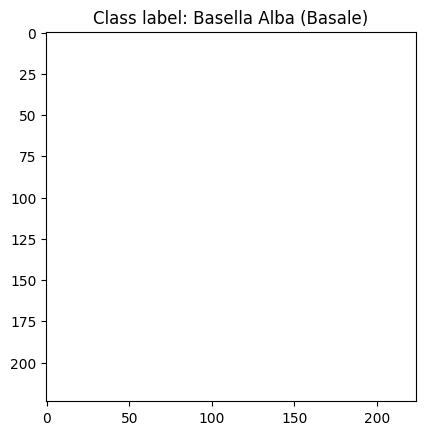

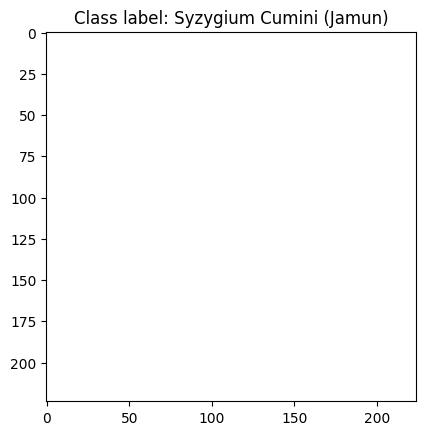

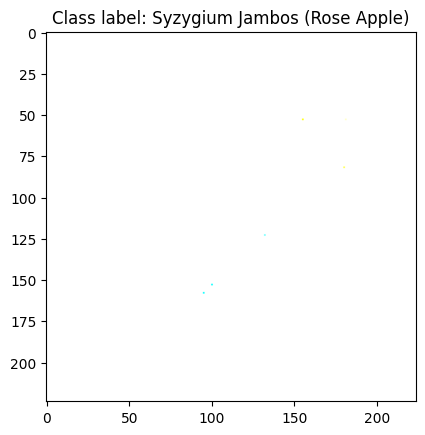

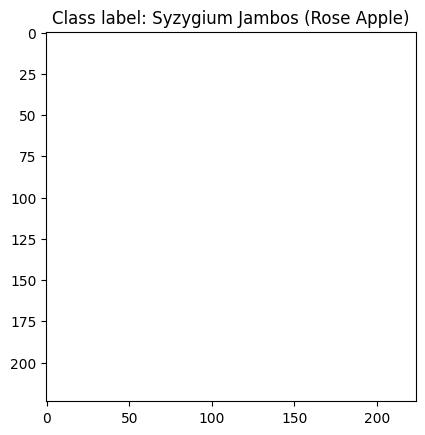

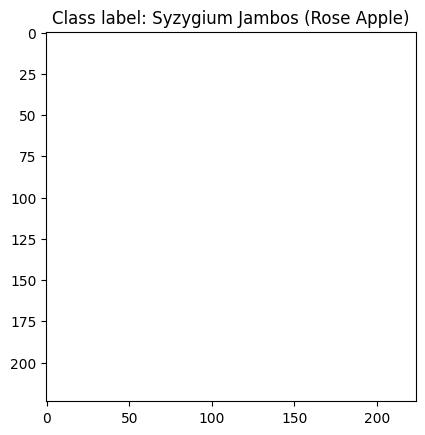

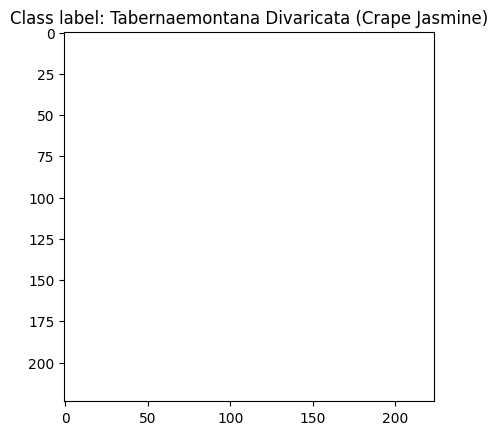

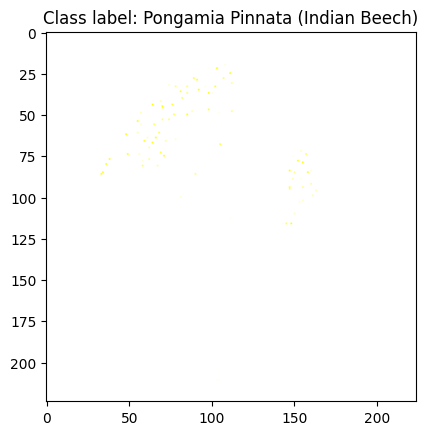

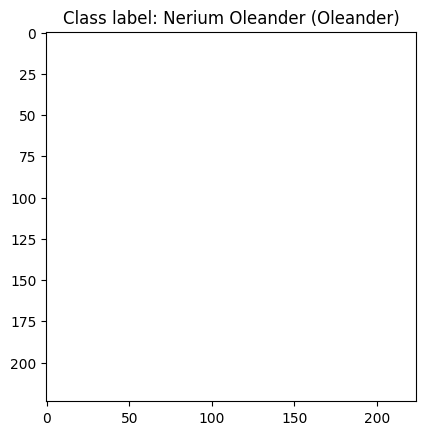

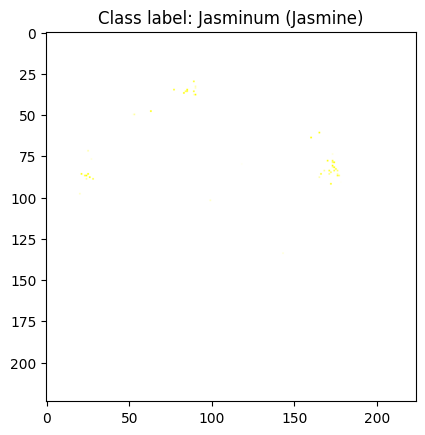

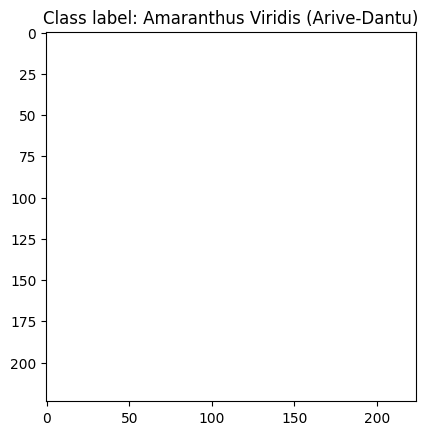

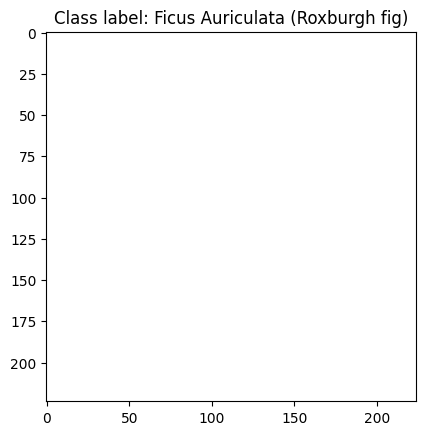

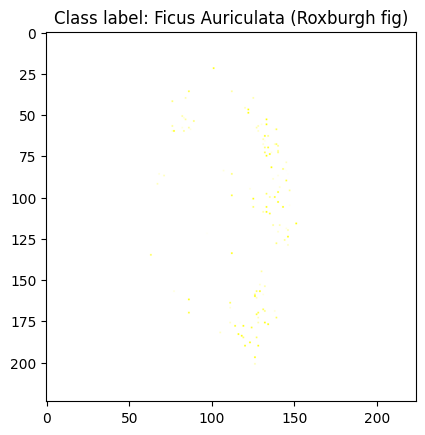

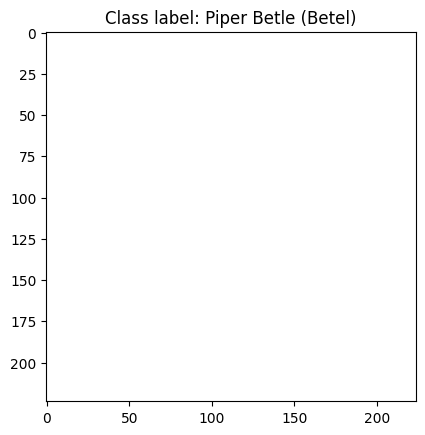

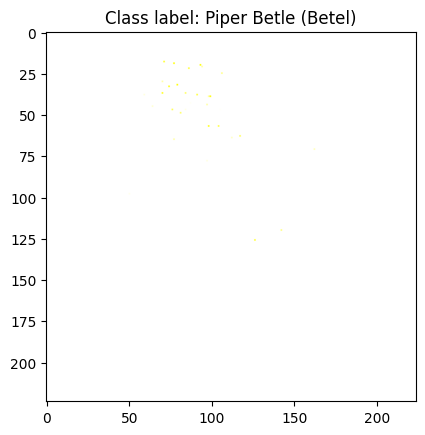

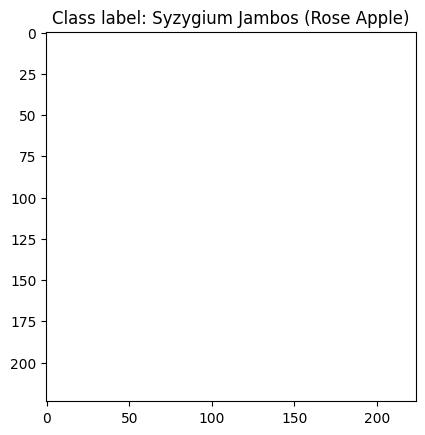

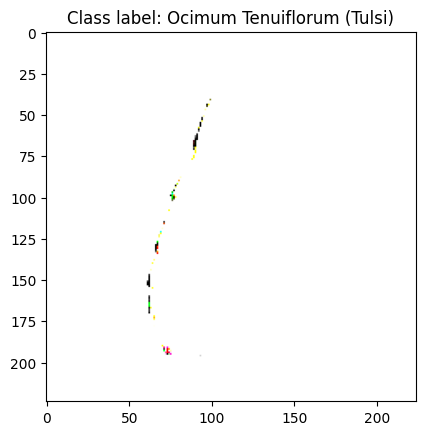

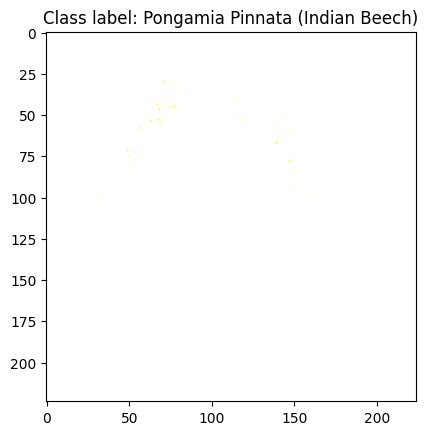

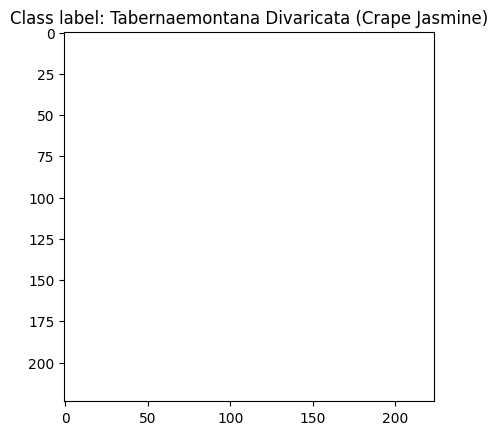

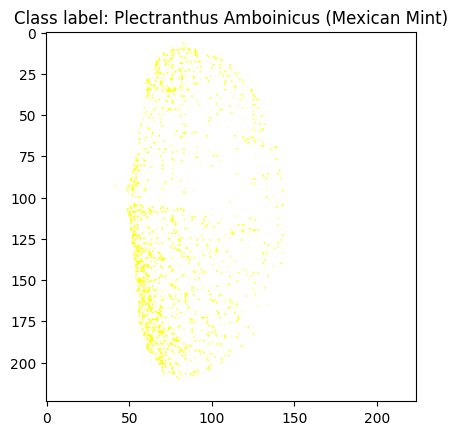

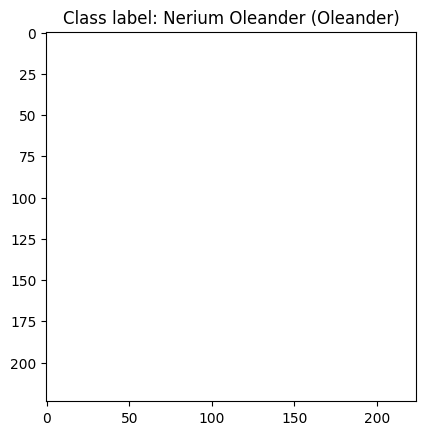

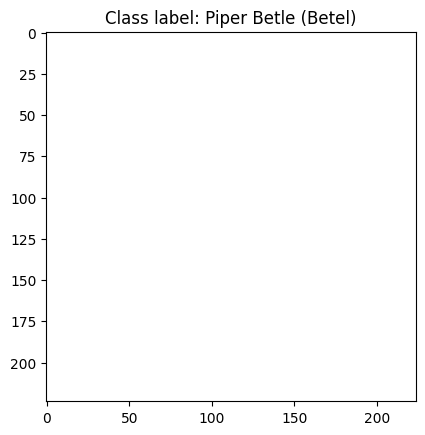

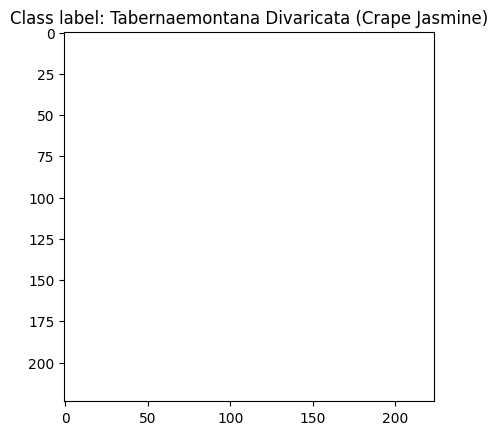

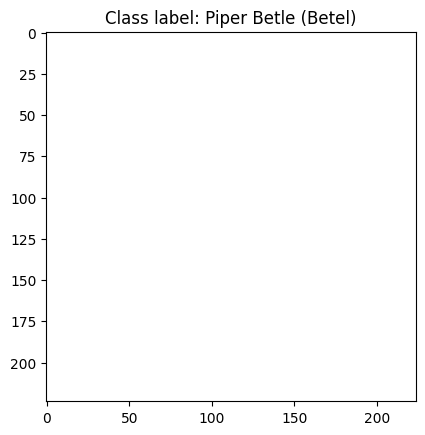

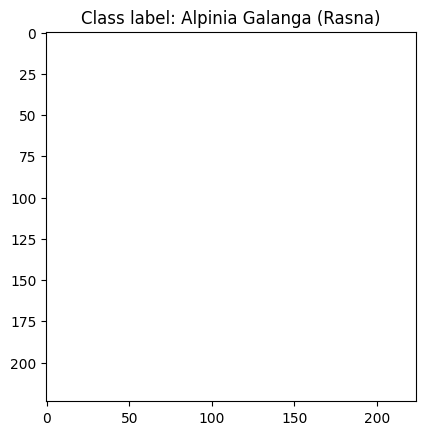

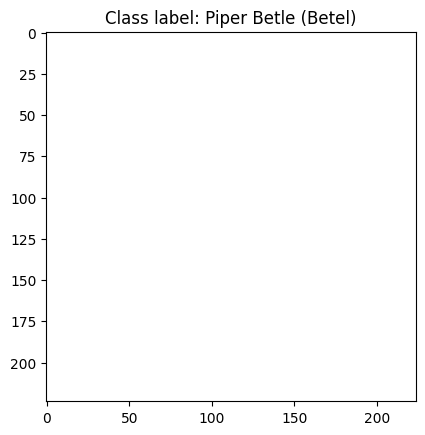

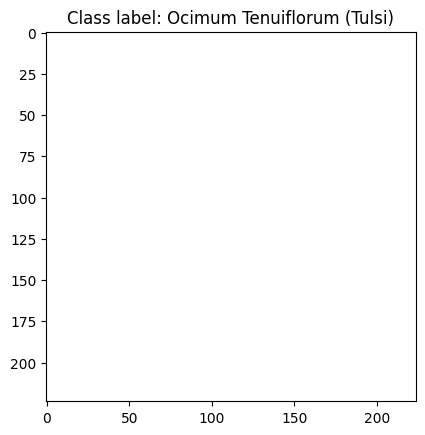

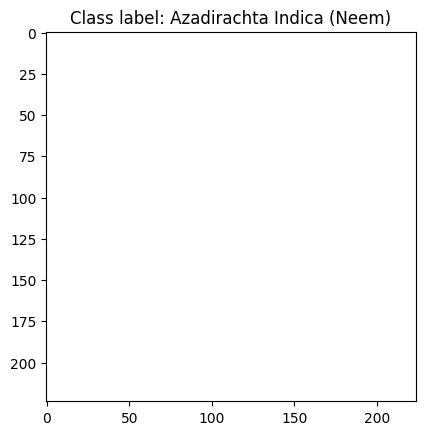

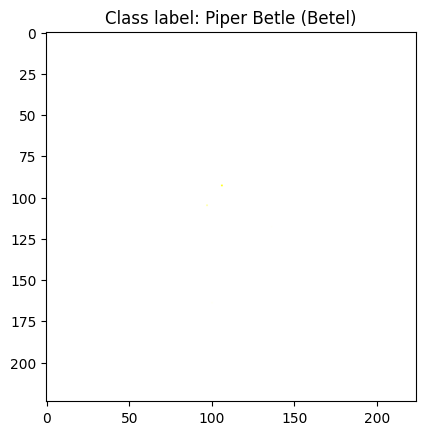

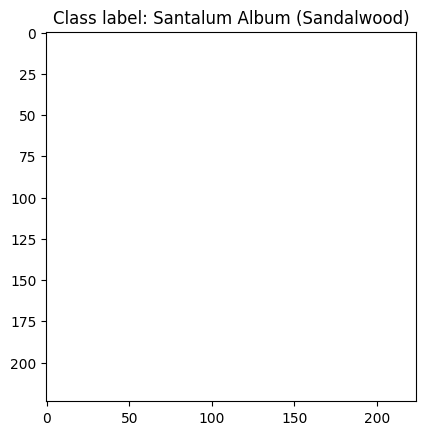

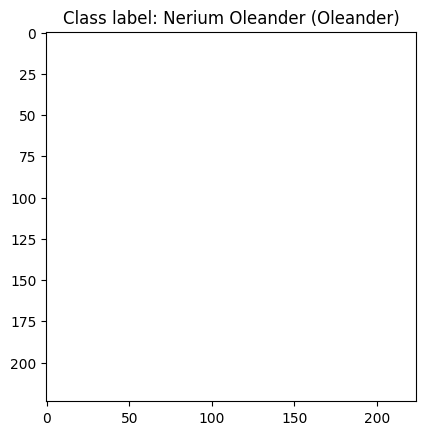

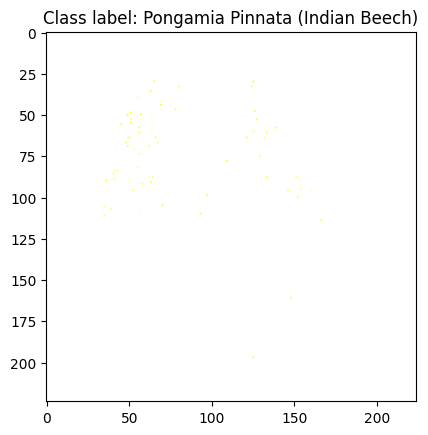

In [ ]:
import numpy as np

# Load the class names from the saved NumPy array
class_names = np.load("/content/drive/MyDrive/artifact/class_names.npy", allow_pickle=True)

# Iterate through misclassified indices and visualize images with class labels
for index in misclassified_indices:
    image, true_label = next(iter(validation_ds.unbatch().skip(index[0]).take(1)))  # Extract an individual image and label

    # Get the class name corresponding to the true label
    class_name = class_names[true_label]

    # Plot the misclassified image along with its class label
    plt.imshow(image)
    plt.title(f'Class label: {class_name}')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate through misclassified indices and visualize images with class labels
for index in misclassified_indices:
    image, true_label = next(iter(validation_ds.unbatch().skip(index[0]).take(1)))  # Extract an individual image and label

    # Assuming you have identified the dotted areas and have a mask
    # Replace this with your actual mask generation logic
    mask = np.zeros_like(image, dtype=bool)
    # Apply the mask to the image to darken the dotted areas
    image[mask] = [0, 0, 0]  # Darken the dotted areas

    # Get the class name corresponding to the true label
    class_name = class_names[true_label]

    # Plot the misclassified image along with its class label
    plt.imshow(image)
    plt.title(f'Class label: {class_name}')
    plt.show()


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
class MaskableModel(keras.Model):
  def __init__(self, model):
    super(MaskableModel, self).__init__(model.inputs, model.outputs)
    self.model = model
  def call(self, inputs, mask=None):
    if mask is not None:
      # Implement masking logic here (e.g., multiply specific layers by the mask)
      # This part requires further development based on the chosen unlearning technique
      pass
    return self.model.call(inputs)

In [ ]:
def compute_ewc_loss(model, old_params, fisher):
    ewc_loss = 0
    for layer in model.layers:
        for weight in layer.weights:
            if weight.name in old_params:
                theta = weight
                mean = old_params[weight.name]
                fisher_matrix = fisher[weight.name]
                ewc_loss += tf.reduce_sum(fisher_matrix * tf.square(theta - mean)) / 2
    return ewc_loss

# Initialize old_params and fisher
old_params = {weight.name: weight for weight in model.weights}
fisher = {weight.name: tf.zeros_like(weight) for weight in model.weights}

# Train the model
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)
for epoch in range(EPOCHS):
    for x_batch, y_batch in train_ds:
        with tf.GradientTape() as tape:
            logits = model(x_batch, training=True)
            loss_value = model.loss(y_batch, logits)
            ewc_loss = compute_ewc_loss(model, old_params, fisher)
            total_loss = loss_value + LAMBDA * ewc_loss
        gradients = tape.gradient(total_loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update Fisher matrix
    for x_batch, y_batch in train_ds:
        with tf.GradientTape() as tape:
            logits = model(x_batch, training=False)
            loss_value = model.loss(y_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_variables)
        for i, gradient in enumerate(gradients):
            fisher[model.weights[i].name] += tf.square(gradient)
    fisher = {name: fisher[name] / len(train_ds) for name in fisher}

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(validation_ds)
    print("Epoch {}, Validation loss: {}, Validation accuracy: {}".format(epoch, val_loss, val_acc))

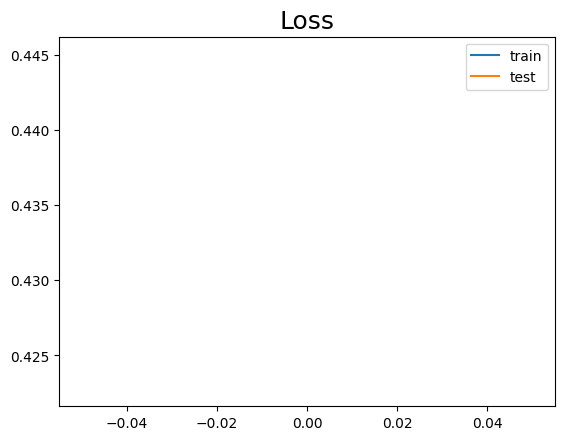

In [ ]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

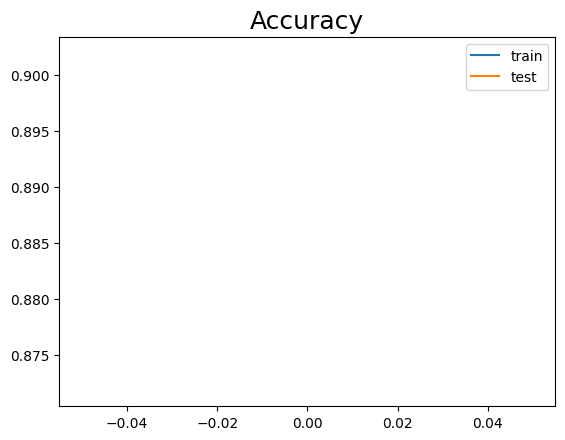

In [ ]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

## Model Performance Analysis

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
Y_train = []
X_train = []

In [ ]:
for data in train_ds:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())

In [ ]:
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

46/46 [==============================] - 813s 18s/step


In [ ]:
y_train_pred_prob.shape

(1468, 30)

In [ ]:
#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=class_names)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{class_names[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )

    return fig

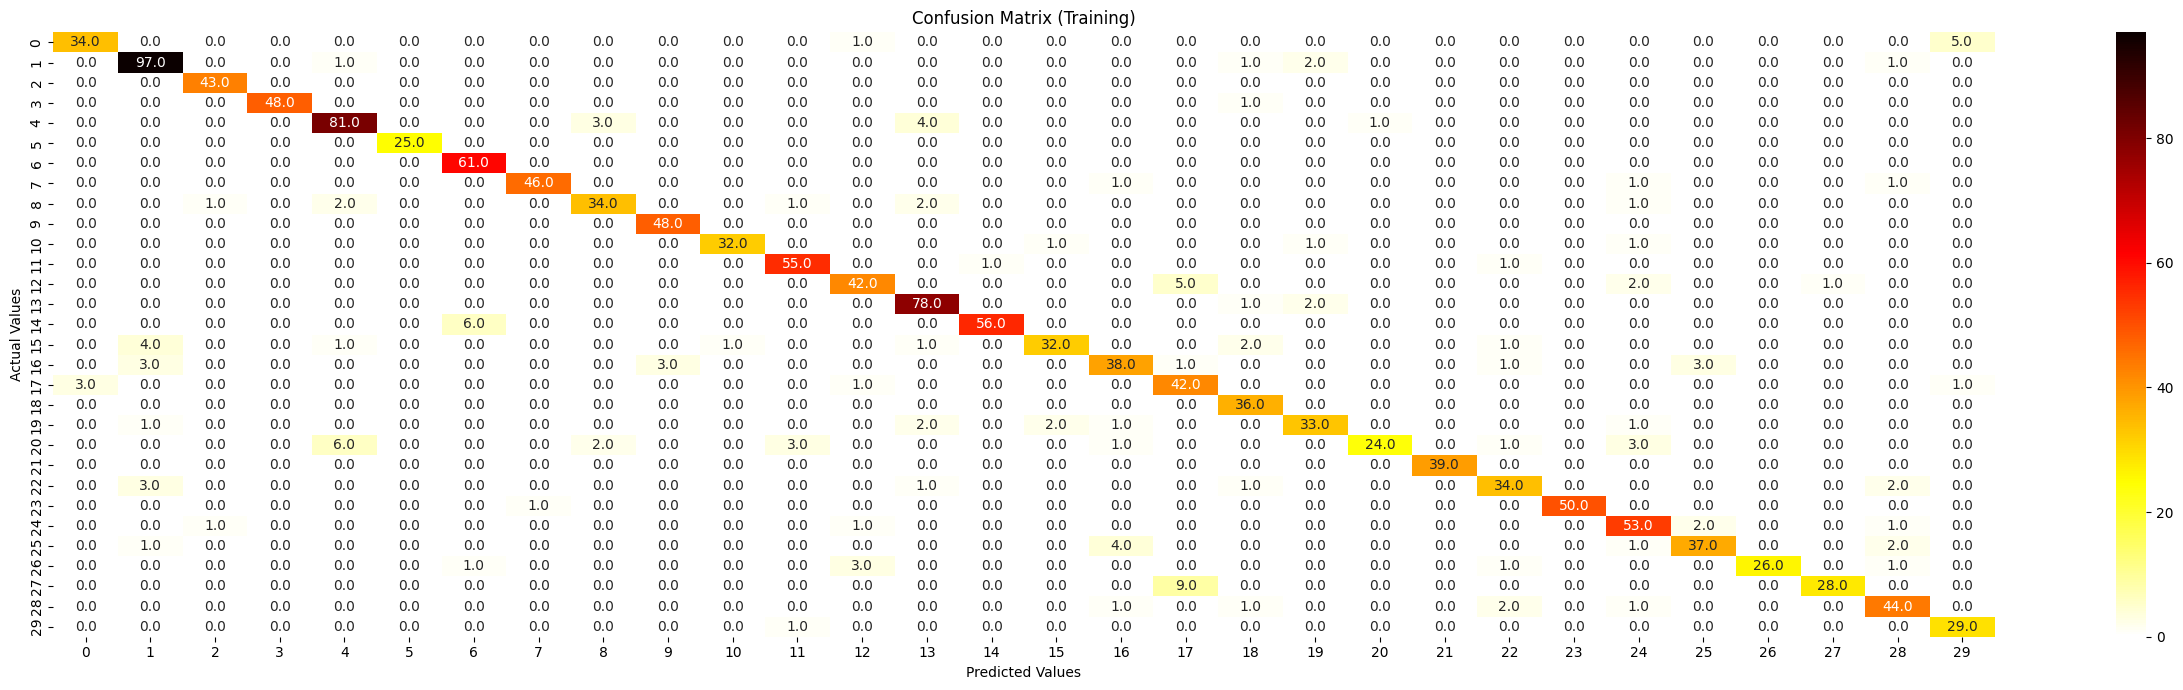

In [ ]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
print("Classification Report for Training")
#print(classification_report(Y_train, y_train_pred))
accuracy = accuracy_score(Y_train, y_train_pred)


Classification Report for Training
Accuracy for Training: 92.25885558583107


In [ ]:
roc_auc_curve(y_train_pred_prob, Y_train)

In [ ]:
X_test = []
y_test = []

In [ ]:
for data in validation_ds:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

12/12 [==============================] - 202s 17s/step


In [ ]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

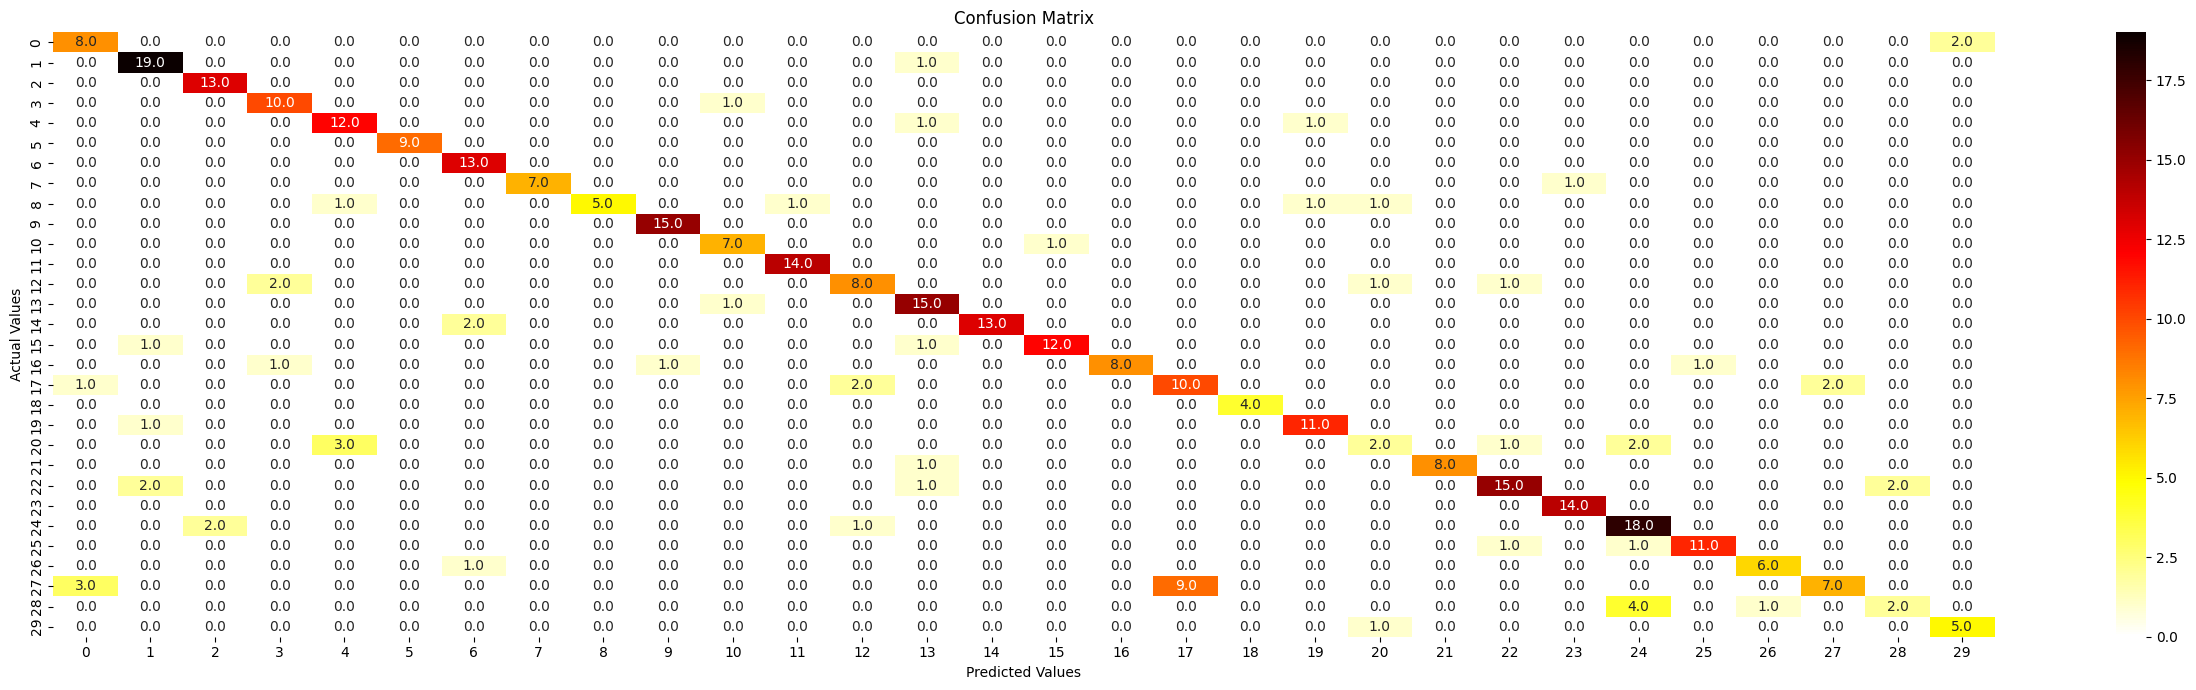

In [ ]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.83      0.95      0.88        20
           2       0.87      1.00      0.93        13
           3       0.77      0.91      0.83        11
           4       0.75      0.86      0.80        14
           5       1.00      1.00      1.00         9
           6       0.81      1.00      0.90        13
           7       1.00      0.88      0.93         8
           8       1.00      0.56      0.71         9
           9       0.94      1.00      0.97        15
          10       0.78      0.88      0.82         8
          11       0.93      1.00      0.97        14
          12       0.73      0.67      0.70        12
          13       0.75      0.94      0.83        16
          14       1.00      0.87      0.93        15
          15       0.92      0.86      0.89        14
          16       1.00      0.73      0.84       

In [ ]:
roc_auc_curve(y_test_pred_prob, y_test)

NameError: name 'roc_auc_curve' is not defined

## Saving Model

In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
save_model(model, '/content/drive/MyDrive/artifact/modelunlearn.h5')